Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Assignment CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Assignment CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:

# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [9]:
import glob
path='/content/gdrive/MyDrive/Colab Notebooks/Assignment CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
orig_path_list = [i for i in glob.glob(os.path.join(path,'*','*.jpg'))]
orig_lesion_list = [os.path.basename(os.path.dirname(y)) for y in orig_path_list]
dataframe_dict_new = dict(zip(orig_path_list, orig_lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

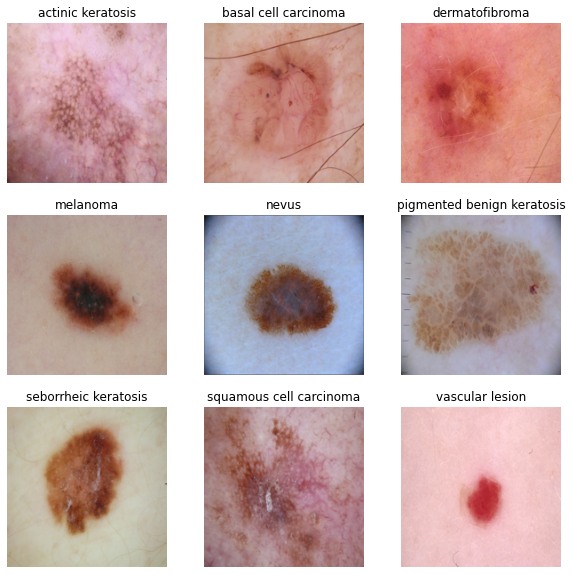

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,10))

for i in range(9):
  ax=plt.subplot(3,3,i+1)
  path = original_df[original_df['Label']==class_names[i]]['Path'].iloc[0]
  image = PIL.Image.open(path).resize((180,180))
  plt.imshow(image)
  plt.title(class_names[i])
  plt.axis('off')


In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here
num_classes = 9

model = Sequential([
    layers.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    layers.Conv2D(16,3,padding='SAME',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32,3,padding='SAME',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64,3,padding='SAME',activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 11s 46ms/step - loss: 2.0106 - accuracy: 0.2578 - val_loss: 1.9053 - val_accuracy: 0.3579
Epoch 2/20
56/56 [==============================] - 1s 13ms/step - loss: 1.7319 - accuracy: 0.3811 - val_loss: 1.6366 - val_accuracy: 0.4385
Epoch 3/20
56/56 [==============================] - 1s 13ms/step - loss: 1.5665 - accuracy: 0.4492 - val_loss: 1.5233 - val_accuracy: 0.4251
Epoch 4/20
56/56 [==============================] - 1s 13ms/step - loss: 1.3637 - accuracy: 0.5234 - val_loss: 1.4956 - val_accuracy: 0.5078
Epoch 5/20
56/56 [==============================] - 1s 13ms/step - loss: 1.2116 - accuracy: 0.5765 - val_loss: 1.3232 - val_accuracy: 0.5459
Epoch 6/20
56/56 [==============================] - 1s 13ms/step - loss: 1.1413 - accuracy: 0.5982 - val_loss: 1.3310 - val_accuracy: 0.5705
Epoch 7/20
56/56 [==============================] - 1s 13ms/step - loss: 1.0714 - accuracy: 0.6228 - val_loss: 1.3523 - val_accuracy: 0.5503
Epoch 8/20
5

### Visualizing training results

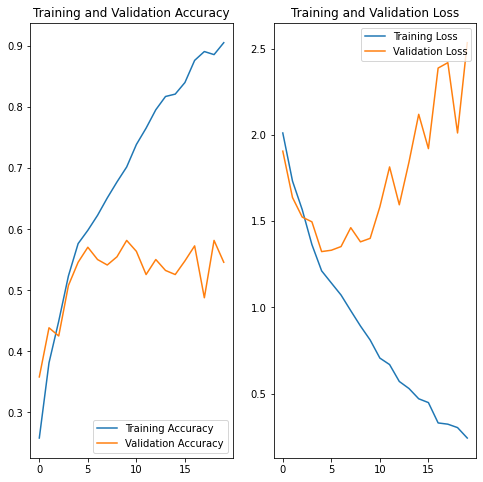

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

- We can clearly see that as the training accuracy is increases the validation accuracy increases up to one point and startes decreasing after around 5 epoch.
- We can also see that the there is a huge gap between the training loss and the validation loss,
- Both of the above clearly show that there is a problem of over fitting.

- Overfitting has occured here since there are a vere small training examples. 

- We use data augmentation, that generates additional training data from our extiting data by random transformation of the extiting data, example, zoom, rotate etc....

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = Sequential([
        layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)                              
])

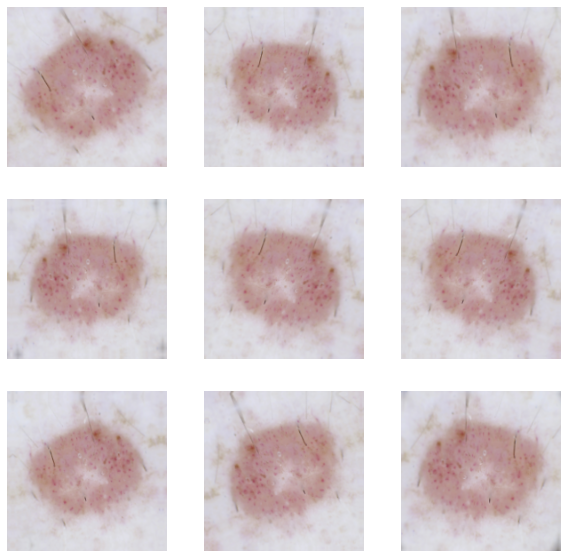

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Todo:
### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
    layers.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    layers.Conv2D(16,3,padding='SAME',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32,3,padding='SAME',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64,3,padding='SAME',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(128,3,padding='SAME',activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes)
])


### Compiling the model

In [21]:
## Your code goes here
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
## your training code
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 1s 17ms/step - loss: 1.8977 - accuracy: 0.2930 - val_loss: 1.7052 - val_accuracy: 0.3937
Epoch 2/20
56/56 [==============================] - 1s 14ms/step - loss: 1.7511 - accuracy: 0.3661 - val_loss: 1.6042 - val_accuracy: 0.4273
Epoch 3/20
56/56 [==============================] - 1s 15ms/step - loss: 1.6472 - accuracy: 0.4023 - val_loss: 1.7272 - val_accuracy: 0.3691
Epoch 4/20
56/56 [==============================] - 1s 15ms/step - loss: 1.5888 - accuracy: 0.4392 - val_loss: 1.5618 - val_accuracy: 0.4519
Epoch 5/20
56/56 [==============================] - 1s 14ms/step - loss: 1.5624 - accuracy: 0.4403 - val_loss: 1.5241 - val_accuracy: 0.4810
Epoch 6/20
56/56 [==============================] - 1s 14ms/step - loss: 1.4942 - accuracy: 0.4810 - val_loss: 1.5734 - val_accuracy: 0.4609
Epoch 7/20
56/56 [==============================] - 1s 15ms/step - loss: 1.4982 - accuracy: 0.4794 - val_loss: 1.4937 - val_accuracy: 0.4810
Epoch 8/20
56

### Visualizing the results

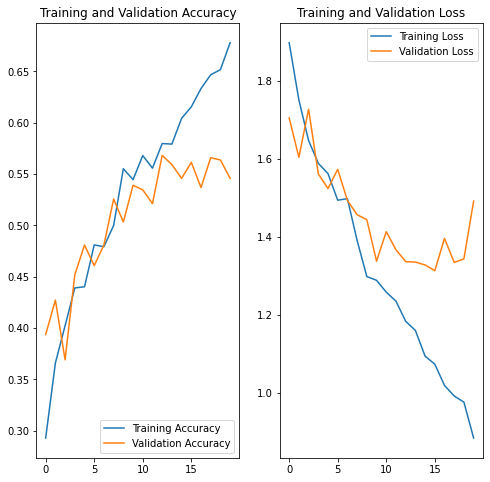

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- We can see that there is a huge effect on the accuracy of the model, even though it seems like it is no overfitting, seems like if we were to run the model for more epochs there still might be some kind of overfitting, since the gap seems to just be opening up (10 to 20 epoch).

- We can clearly observe that the model is performing better than the earlier model, in terms of the gap between the training and the validation score, this shows that the dropouts are having a possitive effect on the model.

- We canb also observe that even though our validation accuracy is increasing, the validation loss keeps increasing, this also tells us that we are making huge errors on the missclassified images.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
## Your code goes here.
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
        Seborrheic Keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
        Pigmented Benign Keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset= '/content/gdrive/MyDrive/Colab Notebooks/Assignment CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset +'/'+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Assignment CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4CB4FD8810>: 100%|██████████| 500/500 [00:08<00:00, 57.84 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Assignment CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F4CB4FC66D0>: 100%|██████████| 500/500 [00:08<00:00, 56.57 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Assignment CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4CB4FCB290>: 100%|██████████| 500/500 [00:08<00:00, 56.38 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Assignment CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F4CB4D2B310>: 100%|██████████| 500/500 [00:46<00:00, 10.86 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Assignment CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F4CB4FB9A50>: 100%|██████████| 500/500 [00:40<00:00, 12.46 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Assignment CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4CB4CB1410>: 100%|██████████| 500/500 [00:08<00:00, 57.52 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Assignment CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F4CB4FD83D0>: 100%|██████████| 500/500 [00:19<00:00, 25.34 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Assignment CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F4CB4DA3DD0>: 100%|██████████| 500/500 [00:08<00:00, 57.36 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Assignment CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4CB4FCB710>: 100%|██████████| 500/500 [00:08<00:00, 57.66 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in path_list]
#lesion_list_new

In [31]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [32]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [33]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [35]:
data_dir_train='/content/gdrive/MyDrive/Colab Notebooks/Assignment CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train' #"path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [38]:
## your code goes here
model = Sequential([
    layers.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    layers.Conv2D(16,3,padding='SAME',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32,3,padding='SAME',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64,3,padding='SAME',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(128,3,padding='SAME',activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [39]:
## your code goes here
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 22, 22, 64)       

#### **Todo:**  Train your model

In [40]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 20s 35ms/step - loss: 1.9878 - accuracy: 0.2281 - val_loss: 1.6782 - val_accuracy: 0.3467
Epoch 2/50
169/169 [==============================] - 2s 14ms/step - loss: 1.6238 - accuracy: 0.3737 - val_loss: 1.5694 - val_accuracy: 0.4046
Epoch 3/50
169/169 [==============================] - 2s 14ms/step - loss: 1.4684 - accuracy: 0.4338 - val_loss: 1.4007 - val_accuracy: 0.4529
Epoch 4/50
169/169 [==============================] - 2s 14ms/step - loss: 1.3259 - accuracy: 0.4826 - val_loss: 1.2734 - val_accuracy: 0.5100
Epoch 5/50
169/169 [==============================] - 2s 14ms/step - loss: 1.2911 - accuracy: 0.4968 - val_loss: 1.1803 - val_accuracy: 0.5471
Epoch 6/50
169/169 [==============================] - 2s 14ms/step - loss: 1.1542 - accuracy: 0.5527 - val_loss: 1.0859 - val_accuracy: 0.5969
Epoch 7/50
169/169 [==============================] - 2s 14ms/step - loss: 1.0883 - accuracy: 0.5762 - val_loss: 1.0172 - val_accuracy: 0.628

#### **Todo:**  Visualize the model results

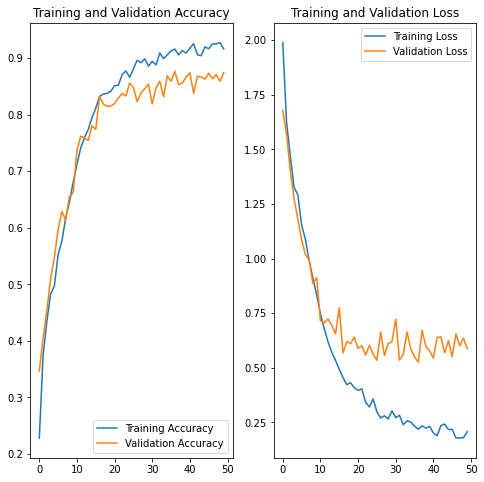

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

- We can clearly observe that most of the overfitting is handeled but there might still be some amount of overfitting left to be handeled, we can use kernal regularization, batch normalization, bias and bias regularization, add more data(not through augmentor).

- Rebalancing the class has helped in handeling the overfitting of the model, and had a possitive impact on the model.



In [42]:
import shutil
for i in class_names:
    shutil.rmtree(str(data_dir_train)+'/'+i+'/output')